In [29]:
import os
import random
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import DataLoader

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from torchsummary import summary

import matplotlib.pyplot as plt
from PIL import Image

# Data preparation

In [30]:
data_paths = {
    "train": "data/cassavaleafdata/train",
    "valid": "data/cassavaleafdata/validation",
    "test": "data/cassavaleafdata/test",
}


# load image from path
def loader(path):
    return Image.open(path)


img_size = 150
train_transforms = transforms.Compose(
    [
        transforms.Resize((150, 150)),
        transforms.ToTensor(),
    ]
)
train_data = datasets.ImageFolder(
    root=data_paths["train"], loader=loader, transform=train_transforms
)

valid_data = datasets.ImageFolder(root=data_paths["valid"], transform=train_transforms)

test_data = datasets.ImageFolder(root=data_paths["test"], transform=train_transforms)

# Wrap datasets in DataLoader
train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_dataloader = DataLoader(valid_data, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

# Modeling

In [5]:
class LeNetClassifier(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=3, out_channels=6, kernel_size=5, padding="same"
        )
        self.avgpool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.avgpool2 = nn.AvgPool2d(kernel_size=2)
        self.flatten = nn.Flatten()
        self.fc_1 = nn.Linear(16 * 35 * 35, 120)
        self.fc_2 = nn.Linear(120, 84)
        self.fc_3 = nn.Linear(84, num_classes)

    def forward(self, inputs):
        outputs = self.conv1(inputs)
        outputs = self.avgpool1(outputs)
        outputs = F.relu(outputs)
        outputs = self.conv2(outputs)
        outputs = self.avgpool2(outputs)
        outputs = F.relu(outputs)
        outputs = self.flatten(outputs)
        outputs = self.fc_1(outputs)
        outputs = self.fc_2(outputs)
        outputs = self.fc_3(outputs)
        return outputs

# Model training

In [31]:
# Training function
def train(
    model, optimizer, criterion, train_dataloader, device, epoch=0, log_interval=50
):
    model.train()
    total_acc, total_count = 0, 0
    losses = []
    start_time = time.time()
    for idx, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(inputs)
        # compute loss
        loss = criterion(predictions, labels)
        losses.append(loss.item())
        # backward
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predictions.argmax(1) == labels).sum().item()
        total_count += labels.size(0)
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f}".format(
                    epoch, idx, len(train_dataloader), total_acc / total_count
                )
            )
            total_acc, total_count = 0, 0
            start_time = time.time()
    epoch_acc = total_acc / total_count
    epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [32]:
# Evaluation function
def evaluate(model, criterion, valid_dataloader, device):
    model.eval()
    total_acc, total_count = 0, 0
    losses = []
    with torch.no_grad():
        for idx, (inputs, labels) in enumerate(valid_dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            predictions = model(inputs)
            loss = criterion(predictions, labels)
            losses.append(loss.item())
            total_acc += (predictions.argmax(1) == labels).sum().item()
            total_count += labels.size(0)
        epoch_acc = total_acc / total_count
        epoch_loss = sum(losses) / len(losses)
    return epoch_acc, epoch_loss

In [33]:
num_classes = len(train_data.classes)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

lenet_model = LeNetClassifier(num_classes)
lenet_model.to(device)
criterion = torch.nn.CrossEntropyLoss()
learning_rate = 2e-4
optimizer = optim.Adam(lenet_model.parameters(), learning_rate)

Using device cpu


In [ ]:
num_epochs = 10
save_model = "./model"
train_accs, train_losses = [], []
eval_accs, eval_losses = [], []
best_loss_eval = 100

# Training loop
for epoch in range(1, num_epochs + 1):
    epoch_start_time = time.time()
    # Training
    train_acc, train_loss = train(
        lenet_model,
        optimizer,
        criterion,
        train_dataloader,
        device,
        epoch,
        log_interval=10,
    )
    train_accs.append(train_acc)
    train_losses.append(train_loss)
    # Evaluation
    eval_acc, eval_loss = evaluate(lenet_model, criterion, valid_dataloader, device)
    eval_accs.append(eval_acc)
    eval_losses.append(eval_loss)
    # Save best model
    if eval_loss < best_loss_eval:
        torch.save(
            lenet_model.state_dict(),
            save_model + "/lenet_model_cassava_leaf_disease.pt",
        )
    # Print loss, acc end epoch
    print("-" * 59)
    print(
        "| End of epoch {:3d} | Time: {:5.2f}s | Train Accuracy {:8.3f} | Train Loss {:8.3f} "
        "| Valid Accuracy {:8.3f} | Valid Loss {:8.3f} ".format(
            epoch,
            time.time() - epoch_start_time,
            train_acc,
            train_loss,
            eval_acc,
            eval_loss,
        )
    )
    print("-" * 59)

# Evaluation

In [36]:
# Load best model
lenet_model.load_state_dict(
    torch.load(
        save_model + "/lenet_model_cassava_leaf_disease.pt",
        map_location=torch.device("cpu"),
    )
)
lenet_model.eval()

/var/folders/y2/hzjfncr92llg100m08nwxmhc0000gn/T/ipykernel_18624/2053221337.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model.load_state_dict(torch.load(save_m

LeNetClassifier(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=same)
  (avgpool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (avgpool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc_1): Linear(in_features=19600, out_features=120, bias=True)
  (fc_2): Linear(in_features=120, out_features=84, bias=True)
  (fc_3): Linear(in_features=84, out_features=5, bias=True)
)

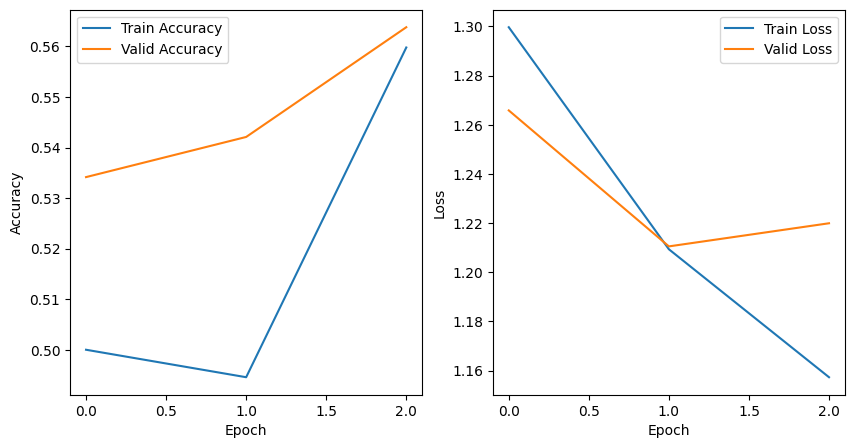

In [37]:
# plot accuracy and loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(eval_accs, label="Valid Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label="Train Loss")
plt.plot(eval_losses, label="Valid Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [39]:
test_acc, test_loss = evaluate(lenet_model, criterion, test_dataloader, device=device)
print(f"Test Accuracy : {test_acc} , Test Loss : {test_loss}")

Test Accuracy : 0.553315649867374 , Test Loss : 1.2177207712399758
